# **FGV EESP**

- ## VAR e VECM - Expectativa de Inflação do Mercado
---



### **Bibliotecas**

In [ ]:
# Modelo VAR
install.packages("vars")

# Modelo VECM
install.packages("tsDyn")

# Função tidy()
install.packages("broom")

# Painel de Gráficos
install.packages("gridExtra")

In [ ]:
library(broom)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(httr)
library(lubridate)
library(readxl)
library(tsDyn)
library(vars)
library(tidyverse)
library(zoo)

### **Dados**

In [ ]:
# Caminho do arquivo original
file_path <- "https://github.com/matheusrmorgado/inflation-expectation/raw/main/data/public_data.xlsx"

# Download do arquivo
download.file(file_path, "public_data.xlsx")

# Ler o arquivo Excel e converter em dataframe
df_public_data <- as.data.frame(read_excel("public_data.xlsx"))

# Converter year e month_name
df_public_data <- df_public_data %>%
  mutate(year = as.numeric(year),  # Converter year para numérico
         month_name = factor(month_name, levels = month.abb, ordered = TRUE))  # Converter month_name para um fator ordenado

# Converter month_date
df_public_data$month_date <- ymd(df_public_data$month_date)  # Converter month_date para formato Date

# Lista de variáveis para transformar em séries temporais
vars_to_convert <- c("month", "market_inflation_expectation", "consumer_inflation_expectation", "consumer_confidence_index", "inflation_target", "inflation_target_lower_bound", "inflation_target_upper_bound", "inflation_target_wtd_avg", "inflation_target_lower_bound_wtd_avg", "inflation_target_upper_bound_wtd_avg", "ipca", "selic", "selic_deflated", "real_household_income", "real_household_income_trend", "real_household_income_gap", "real_exchange_rate", "real_exchange_rate_trend", "real_exchange_rate_gap", "gdp", "primary_fiscal_result", "primary_fiscal_result_to_gdp", "ipca_lag", "selic_deflated_lag", "primary_fiscal_result_to_gdp_lag", "real_exchange_rate_gap_lag", "real_household_income_gap_lag", "consumer_confidence_index_lag", "search_term_ipca", "search_term_selic", "search_term_inflation")

# Loop para transformar as variáveis em séries temporais
for (var in vars_to_convert) {
  df_public_data[[var]] <- ts(df_public_data[[var]], start = c(2006, 1), frequency = 12)
}

In [ ]:
str(df_public_data)

'data.frame':	213 obs. of  34 variables:
 $ year                                : num  2006 2006 2006 2006 2006 ...
 $ month_name                          : Ord.factor w/ 12 levels "Jan"<"Feb"<"Mar"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ month_date                          : Date, format: "2006-01-01" "2006-02-01" ...
 $ month                               : Time-Series  from 2006 to 2024: 2006 2006 2006 2006 2006 ...
 $ market_inflation_expectation        : Time-Series  from 2006 to 2024: 4.58 4.49 4.36 4.16 4.18 4.25 4.4 4.48 4.29 4.05 ...
 $ consumer_inflation_expectation      : Time-Series  from 2006 to 2024: 6.9 7 6.9 6.5 6.7 6.3 6.9 6.4 6.3 5.8 ...
 $ consumer_confidence_index           : Time-Series  from 2006 to 2024: 93.3 92.8 93 91.8 90.7 90.7 91.2 91.8 91.5 94.3 ...
 $ inflation_target                    : Time-Series  from 2006 to 2024: 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 ...
 $ inflation_target_lower_bound        : Time-Series  from 2006 to 2024: 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2

### **Modelo VAR**

In [ ]:
# Selecionar variáveis do modelo VAR
var_model_variables <- df_public_data[, c("market_inflation_expectation", "inflation_target_wtd_avg", "ipca", "primary_fiscal_result_to_gdp", "real_exchange_rate_gap", "real_household_income_gap", "selic_deflated")]

# Renomear variáveis
var_model_variables <- var_model_variables %>% rename(inflation_expectation = market_inflation_expectation)
var_model_variables <- var_model_variables %>% rename(inflation_target = inflation_target_wtd_avg)
var_model_variables <- var_model_variables %>% rename(net_government_debt = primary_fiscal_result_to_gdp)
var_model_variables <- var_model_variables %>% rename(real_selic = selic_deflated)

In [ ]:
# Selecionar a ordem adequada do modelo VAR
lag_select <- VARselect(var_model_variables, lag.max = 12, type = "const")

print(lag_select$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    12      2      2      4 


In [ ]:
# Ajustar o modelo VAR com uma ordem escolhida
var_model = VAR(var_model_variables, p = 2, type = "const")

tidy(var_model)

group,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
inflation_expectation,inflation_expectation.l1,1.096616851,0.073934515,14.8322723,7.277619e-34
inflation_expectation,inflation_target.l1,2.779499232,3.062368110,0.9076307,3.651880e-01
inflation_expectation,ipca.l1,0.080851429,0.054365929,1.4871709,1.385766e-01
inflation_expectation,net_government_debt.l1,-3.304913842,1.860566247,-1.7762946,7.723570e-02
inflation_expectation,real_exchange_rate_gap.l1,0.006103564,0.003757521,1.6243594,1.059062e-01
inflation_expectation,real_household_income_gap.l1,0.067992225,0.036104489,1.8832070,6.115343e-02
inflation_expectation,real_selic.l1,0.084865452,0.048845991,1.7374087,8.388588e-02
inflation_expectation,inflation_expectation.l2,-0.266093892,0.071866277,-3.7026252,2.773252e-04
inflation_expectation,inflation_target.l2,-2.796956750,3.090132562,-0.9051252,3.665103e-01


In [ ]:
summary(var_model)


VAR Estimation Results:
Endogenous variables: inflation_expectation, inflation_target, ipca, net_government_debt, real_exchange_rate_gap, real_household_income_gap, real_selic 
Deterministic variables: const 
Sample size: 211 
Log Likelihood: 1299.235 
Roots of the characteristic polynomial:
1.002 1.002 0.9393 0.9393 0.8649 0.8649 0.8216 0.8216 0.6044 0.6044 0.5572 0.338 0.338 0.1475
Call:
VAR(y = var_model_variables, p = 2, type = "const")


Estimation results for equation inflation_expectation: 
inflation_expectation = inflation_expectation.l1 + inflation_target.l1 + ipca.l1 + net_government_debt.l1 + real_exchange_rate_gap.l1 + real_household_income_gap.l1 + real_selic.l1 + inflation_expectation.l2 + inflation_target.l2 + ipca.l2 + net_government_debt.l2 + real_exchange_rate_gap.l2 + real_household_income_gap.l2 + real_selic.l2 + const 

                              Estimate Std. Error t value Pr(>|t|)    
inflation_expectation.l1      1.096617   0.073935  14.832  < 2e-16 ***
infl

In [ ]:
# Serial Correlation
serial_test <- serial.test(var_model, lags.pt = 12, type = "PT.asymptotic")

print(serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 860.23, df = 490, p-value < 2.2e-16



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 860.23, df = 490, p-value < 2.2e-16



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [ ]:
# Heteroscedasticity
arch_test <- arch.test(var_model, lags.multi = 12, multivariate.only = TRUE)

print(arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 5572, df = 9408, p-value = 1



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 5572, df = 9408, p-value = 1



**Resultado**

- Como o p-value é **maior** que um nível de significância de 5%, pode-se afirmar que o modelo não possui heteroscedasticidade

In [ ]:
# Normal Distribution of Residuals
normal_test <- normality.test(var_model, multivariate.only = TRUE)

print(normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2578.8, df = 14, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 212.35, df = 7, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2366.4, df = 7, p-value < 2.2e-16




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2578.8, df = 14, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 212.35, df = 7, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 2366.4, df = 7, p-value < 2.2e-16




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

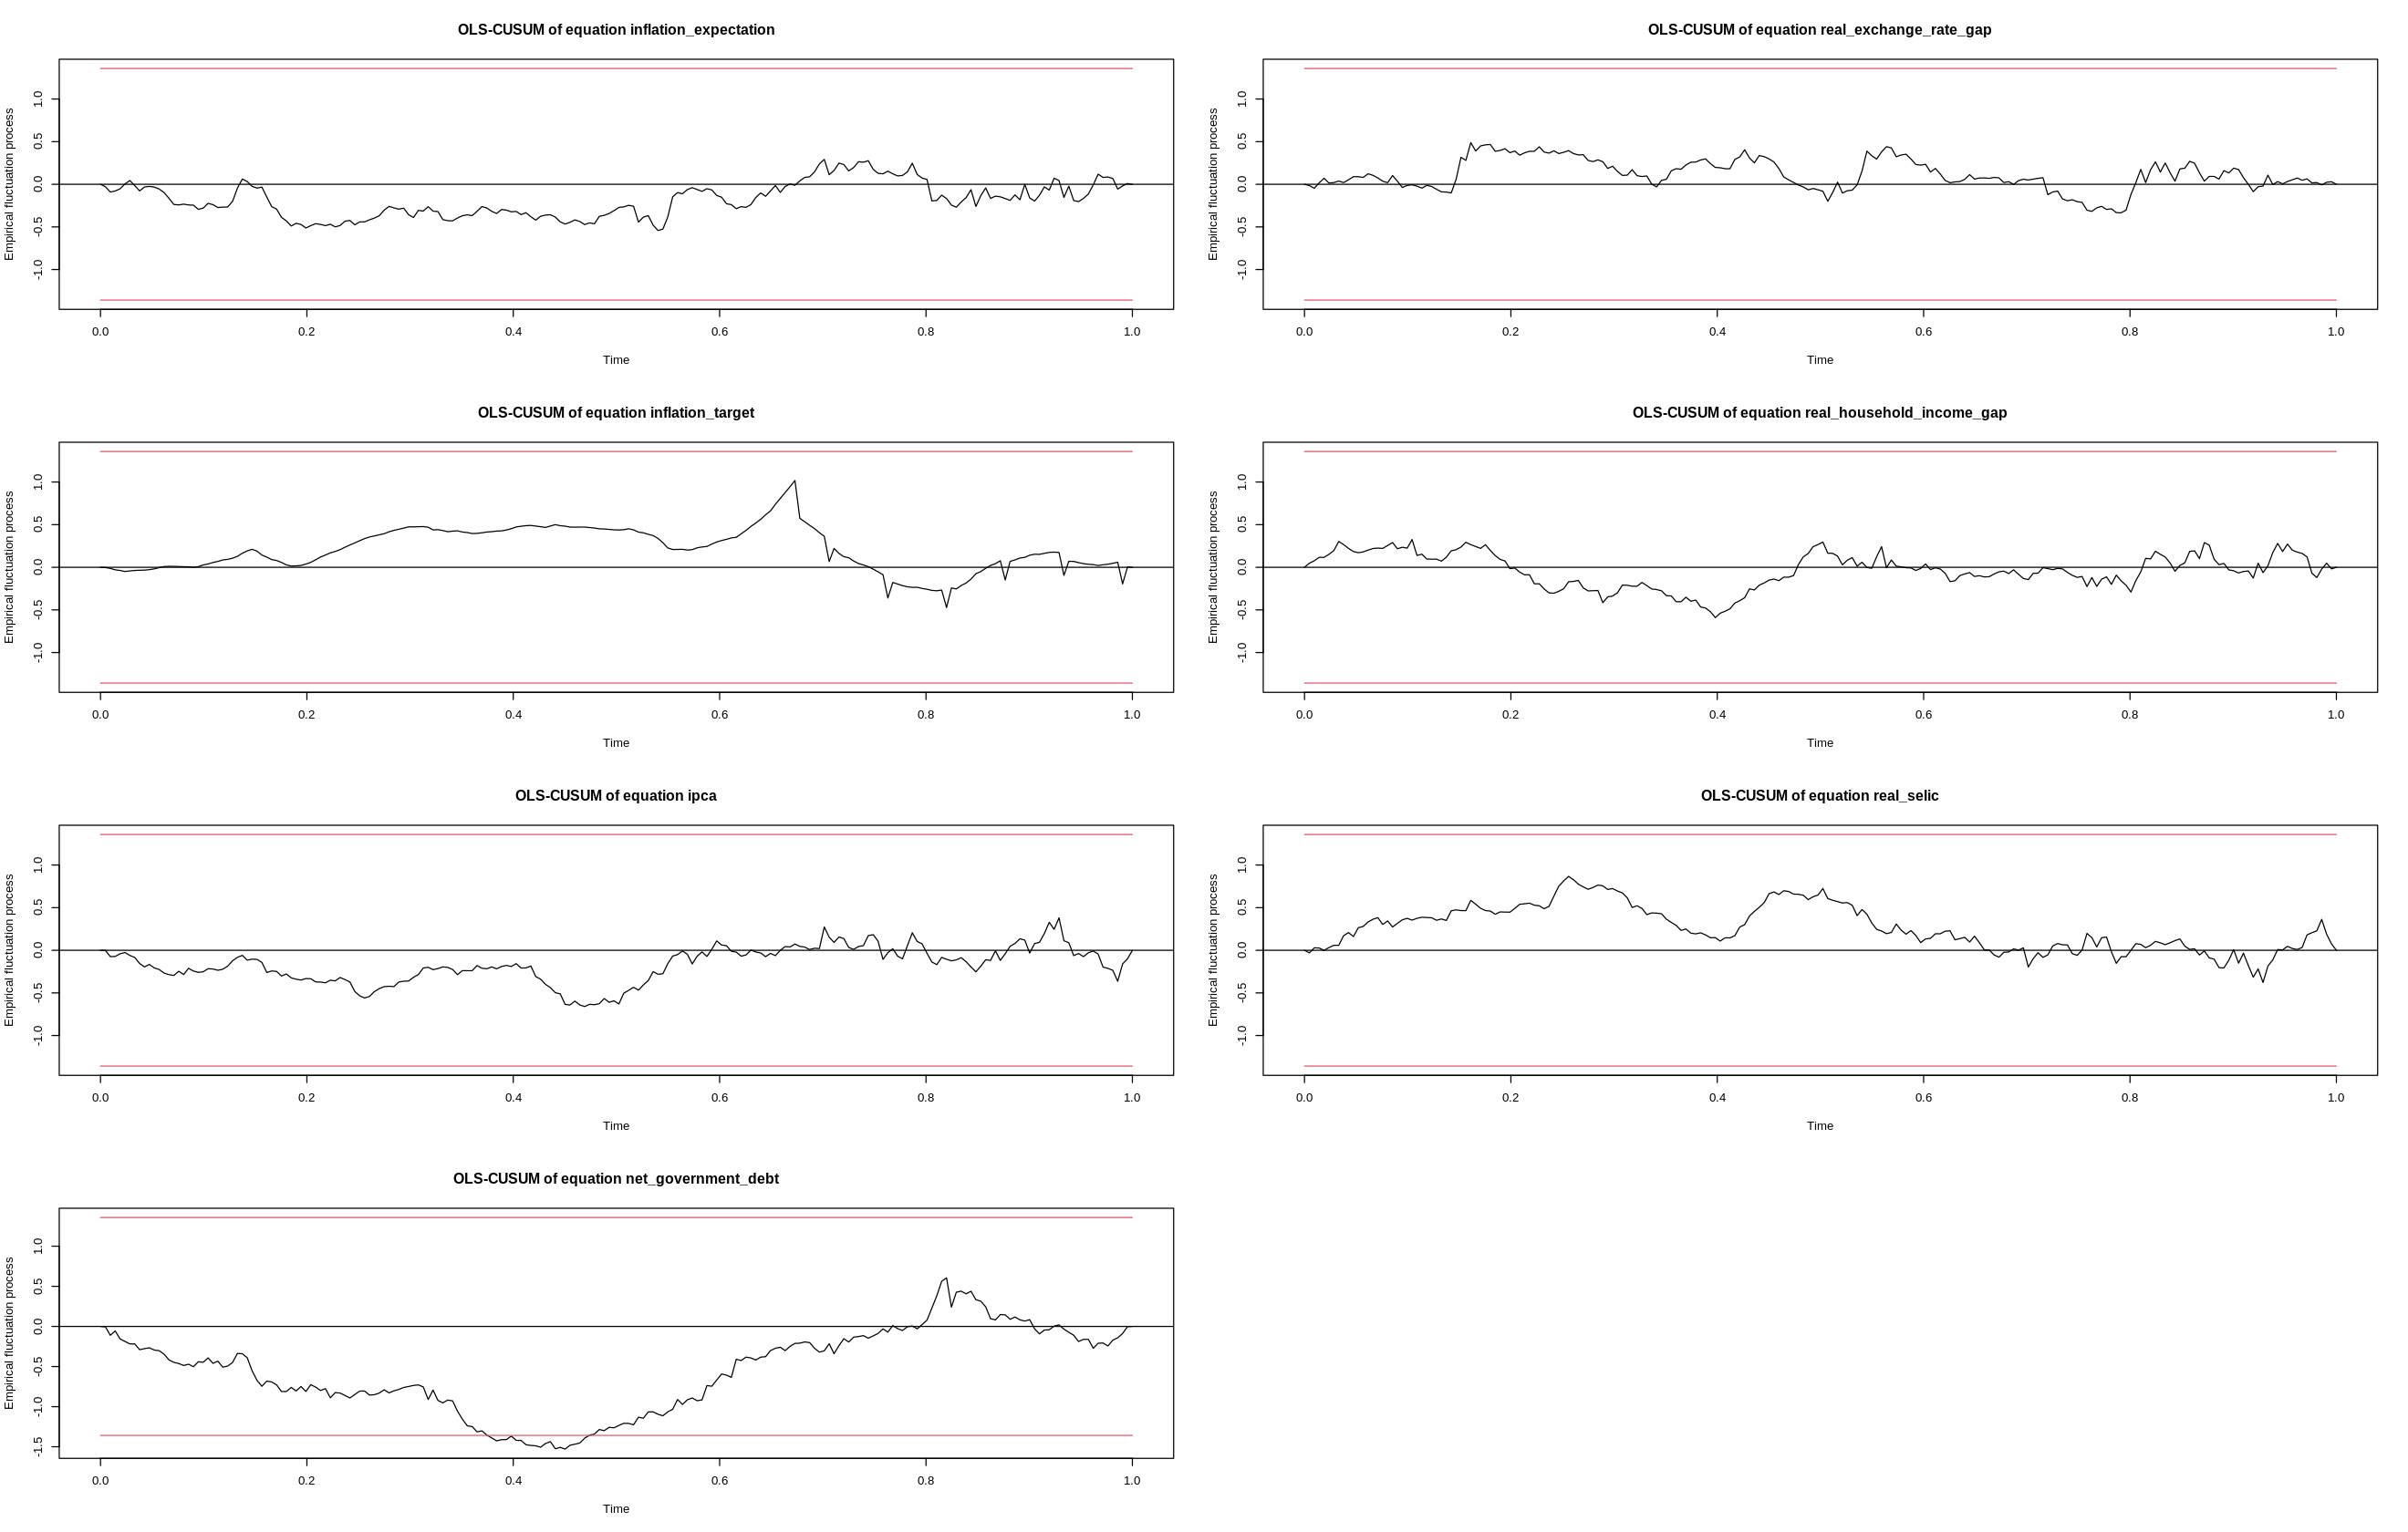

In [ ]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 22, repr.plot.height = 14)

# Structural Breaks in Residuals
stability_test <- stability(var_model, type = "OLS-CUSUM")

plot(stability_test)

**Resultado**

- Como os valores estão entre as barras vermelhas, com exceção da variável relacionada ao resultado fiscal, pode-se afirmar que não há quebra estrutural nos resíduos

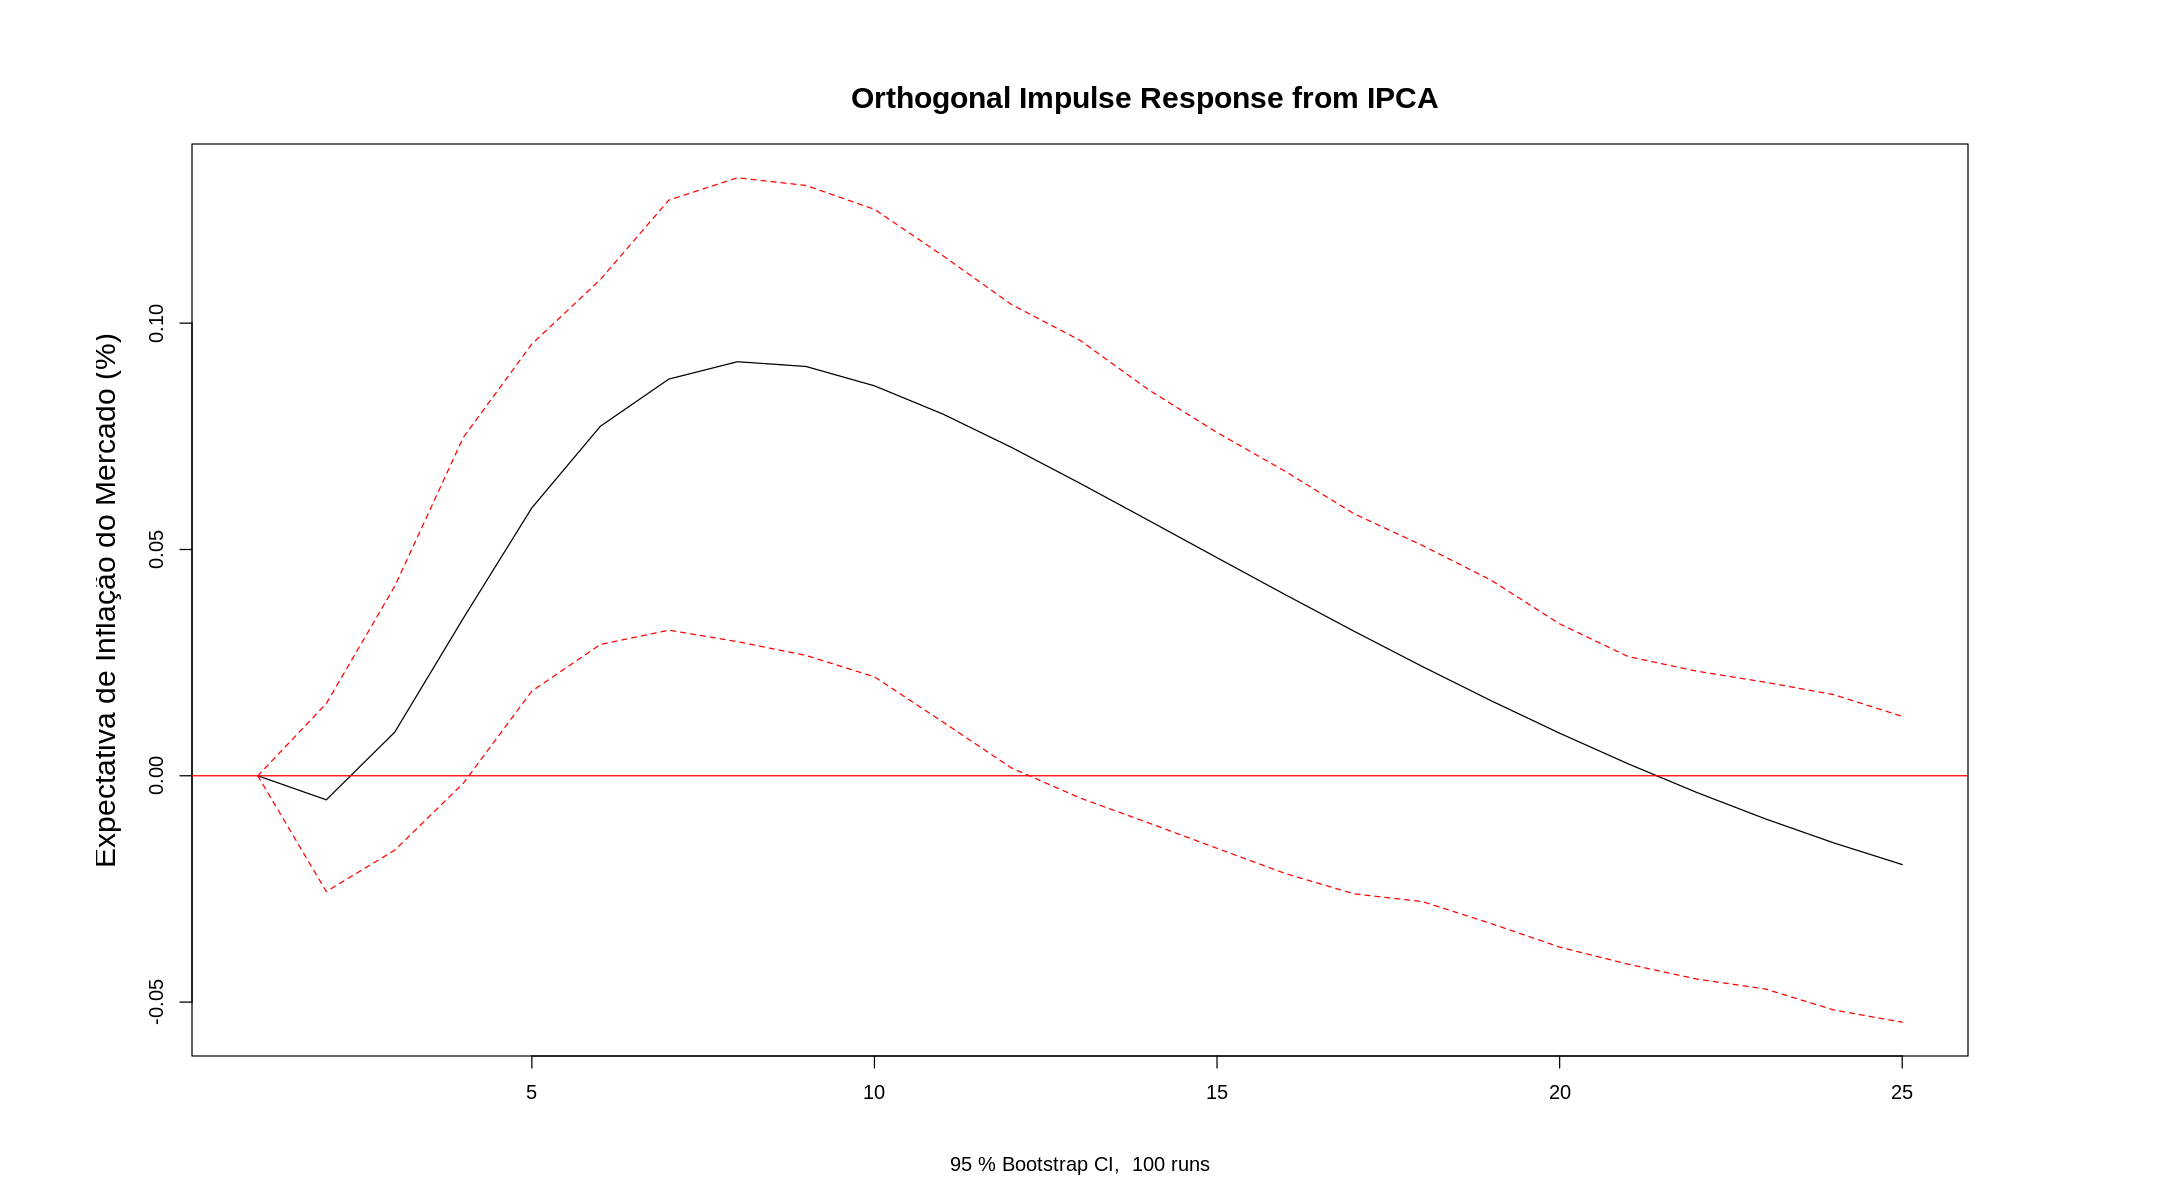

In [ ]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 18, repr.plot.height = 10)

# Impulse Response Function
market_expectation_impulse = irf(var_model, impulse = "ipca", response = "inflation_expectation", n.ahead = 24, boot = TRUE)

# Criar o gráfico com tamanho de rótulo do eixo y aumentado
plot(market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)", main = "", cex.lab = 1.5)
title("Orthogonal Impulse Response from IPCA", cex.main = 1.5)

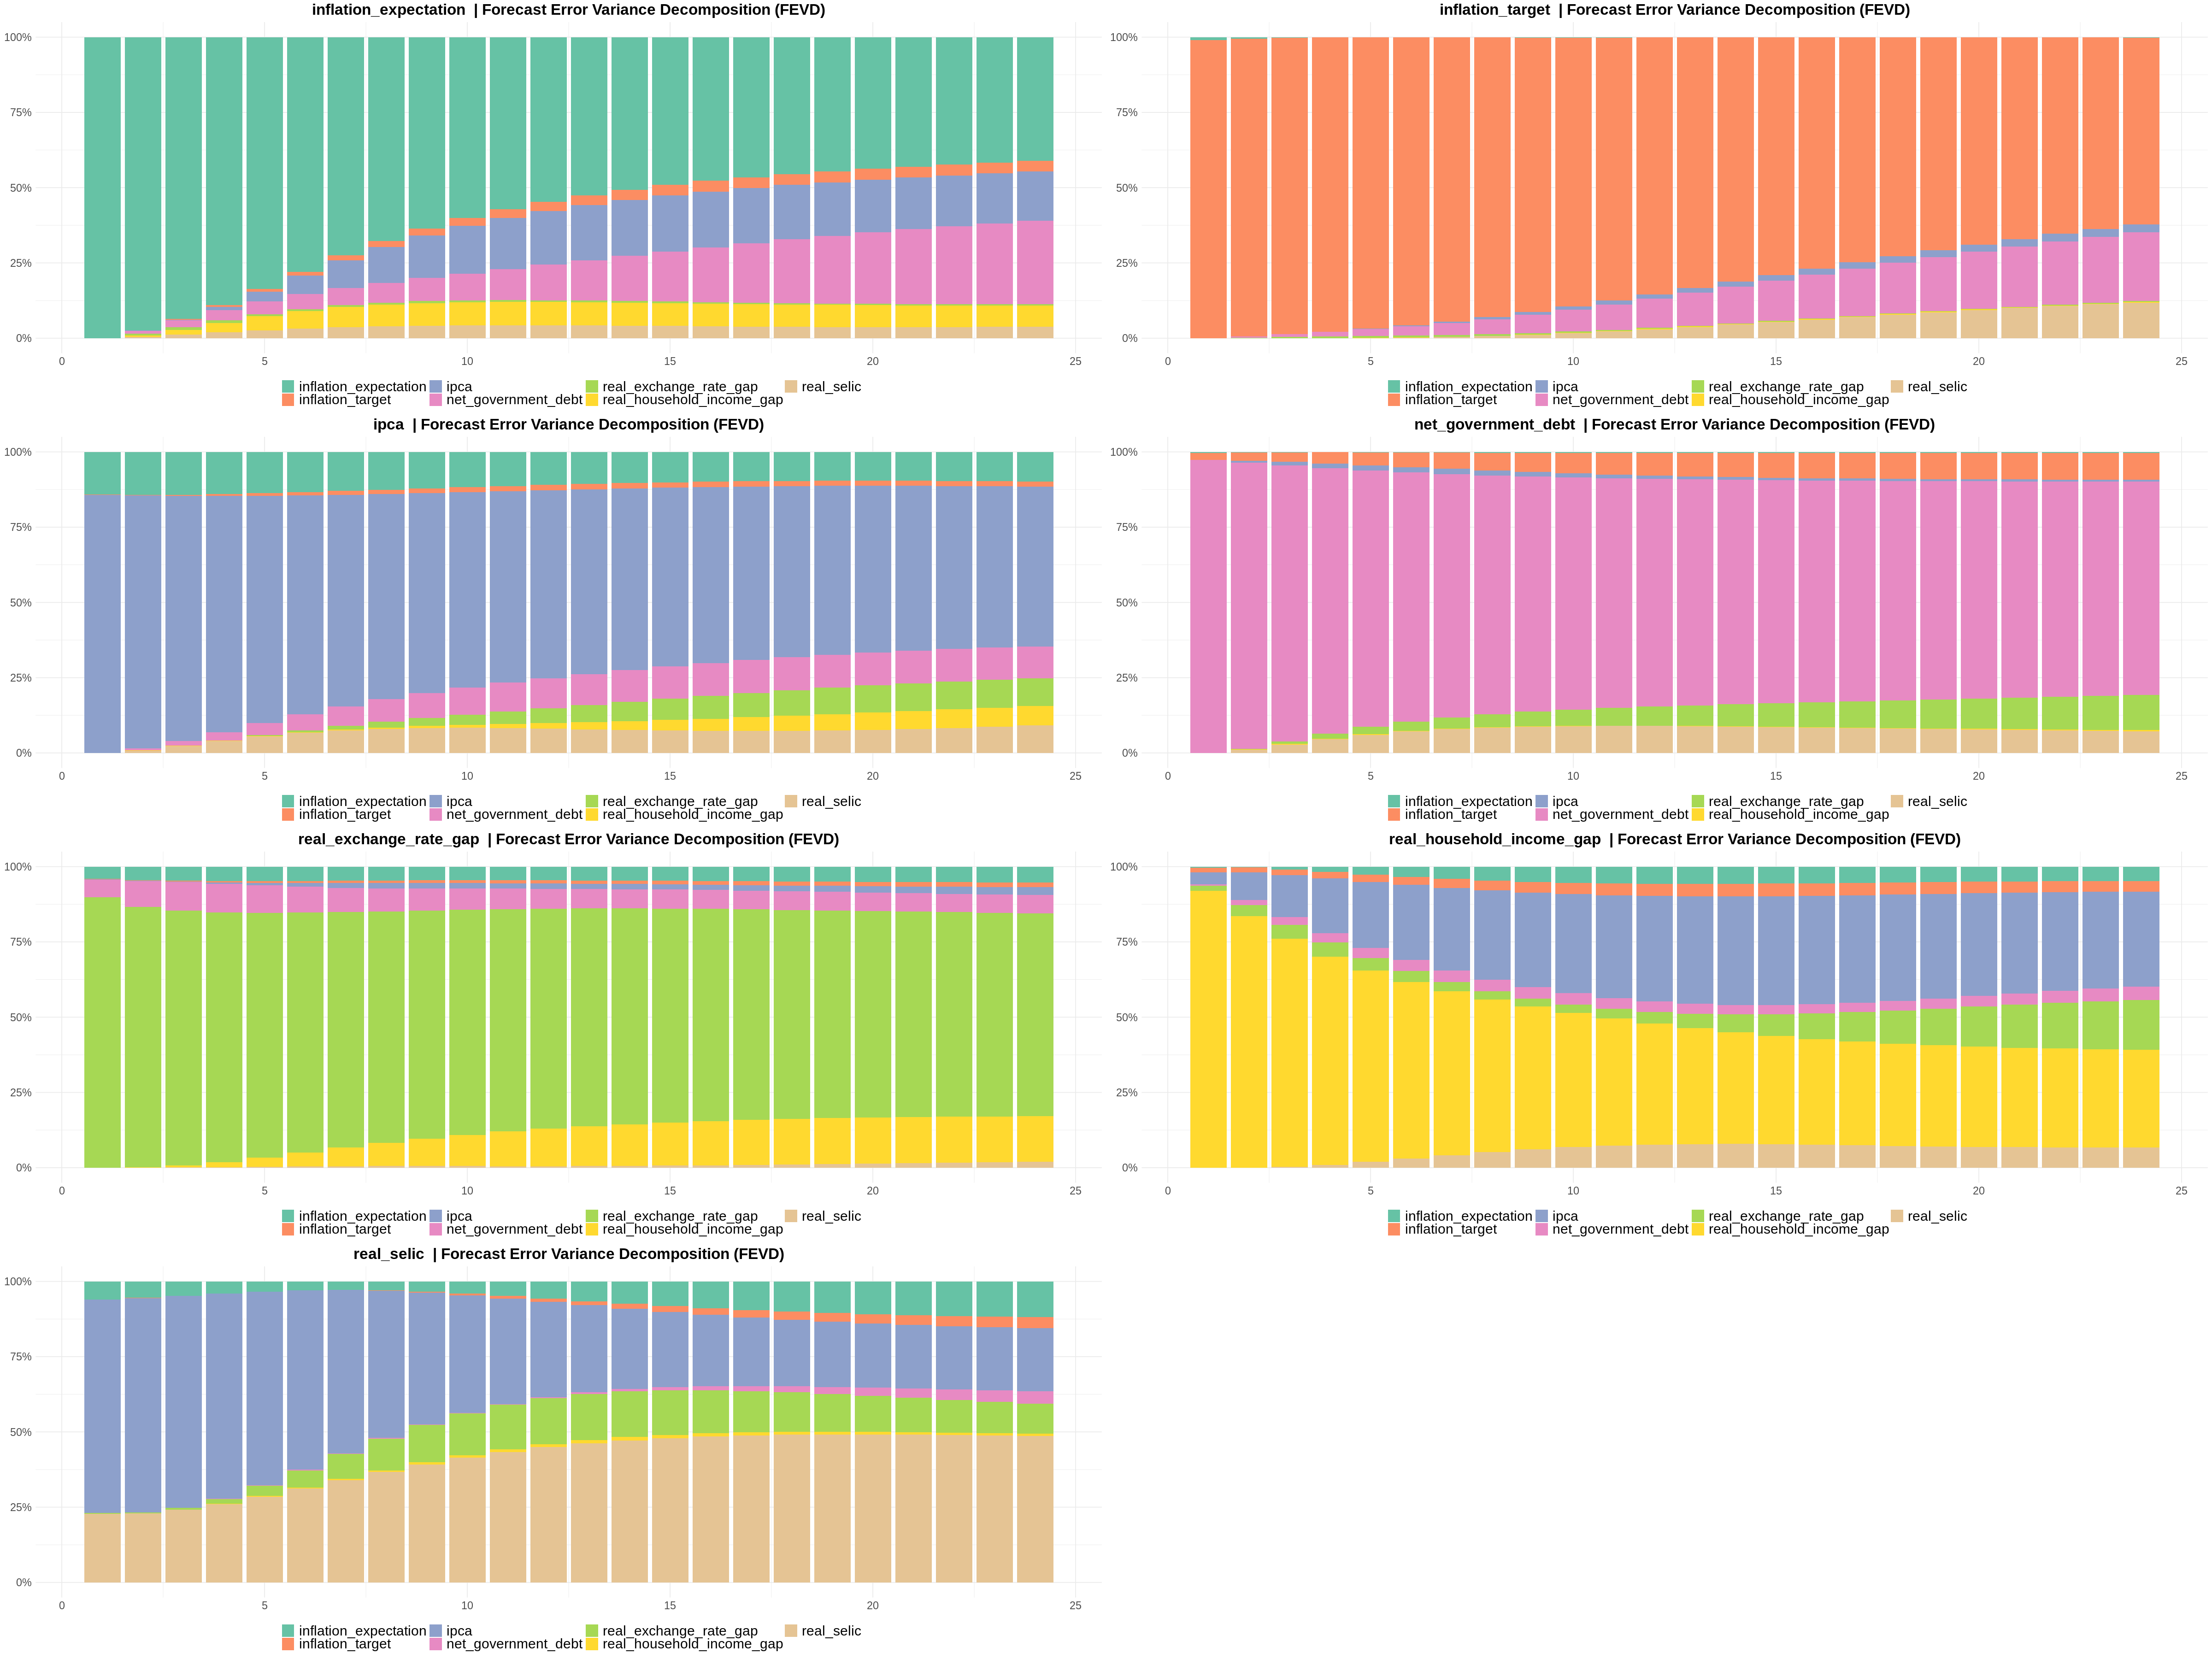

In [ ]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 40, repr.plot.height = 30)

# Função de Variação de Valores Extremos
fevd_model <- fevd(var_model, n.ahead = 24)

# Criar uma lista com os data frames
data_list <- list(
  inflation_expectation = as.data.frame(fevd_model$inflation_expectation),
  inflation_target = as.data.frame(fevd_model$inflation_target),
  ipca = as.data.frame(fevd_model$ipca),
  net_government_debt = as.data.frame(fevd_model$net_government_debt),
  real_exchange_rate_gap = as.data.frame(fevd_model$real_exchange_rate_gap),
  real_household_income_gap = as.data.frame(fevd_model$real_household_income_gap),
  real_selic = as.data.frame(fevd_model$real_selic)
)

# Adicionar a coluna "Mes" de 1 a 24 a cada data frame
data_list <- lapply(data_list, function(df) {
  df$Mes <- 1:24
  return(df)
})

# Função para criar os gráficos
create_stacked_bar_plot <- function(data, title) {
  ggplot(data, aes(x = Mes, y = value, fill = Variavel)) +
    geom_bar(stat = "identity") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_brewer(palette = "Set2") +
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "bottom",
      axis.text = element_text(size = 14),
      legend.text = element_text(size = 18),
      plot.title = element_text(hjust = 0.5, size = 20, face = "bold")
    ) +
    labs(fill = NULL) +
    ggtitle(title)
}

# Criar os gráficos empilhados e armazená-los em uma lista
plot_list <- lapply(names(data_list), function(name) {
  data <- data_list[[name]]
  title <- paste(name, " | Forecast Error Variance Decomposition (FEVD)")
  data_long <- pivot_longer(data, cols = -Mes, names_to = "Variavel", values_to = "value")
  create_stacked_bar_plot(data_long, title)
})

# Plotar os gráficos em um painel
grid.arrange(grobs = plot_list, ncol = 2)  # Altere ncol conforme necessário

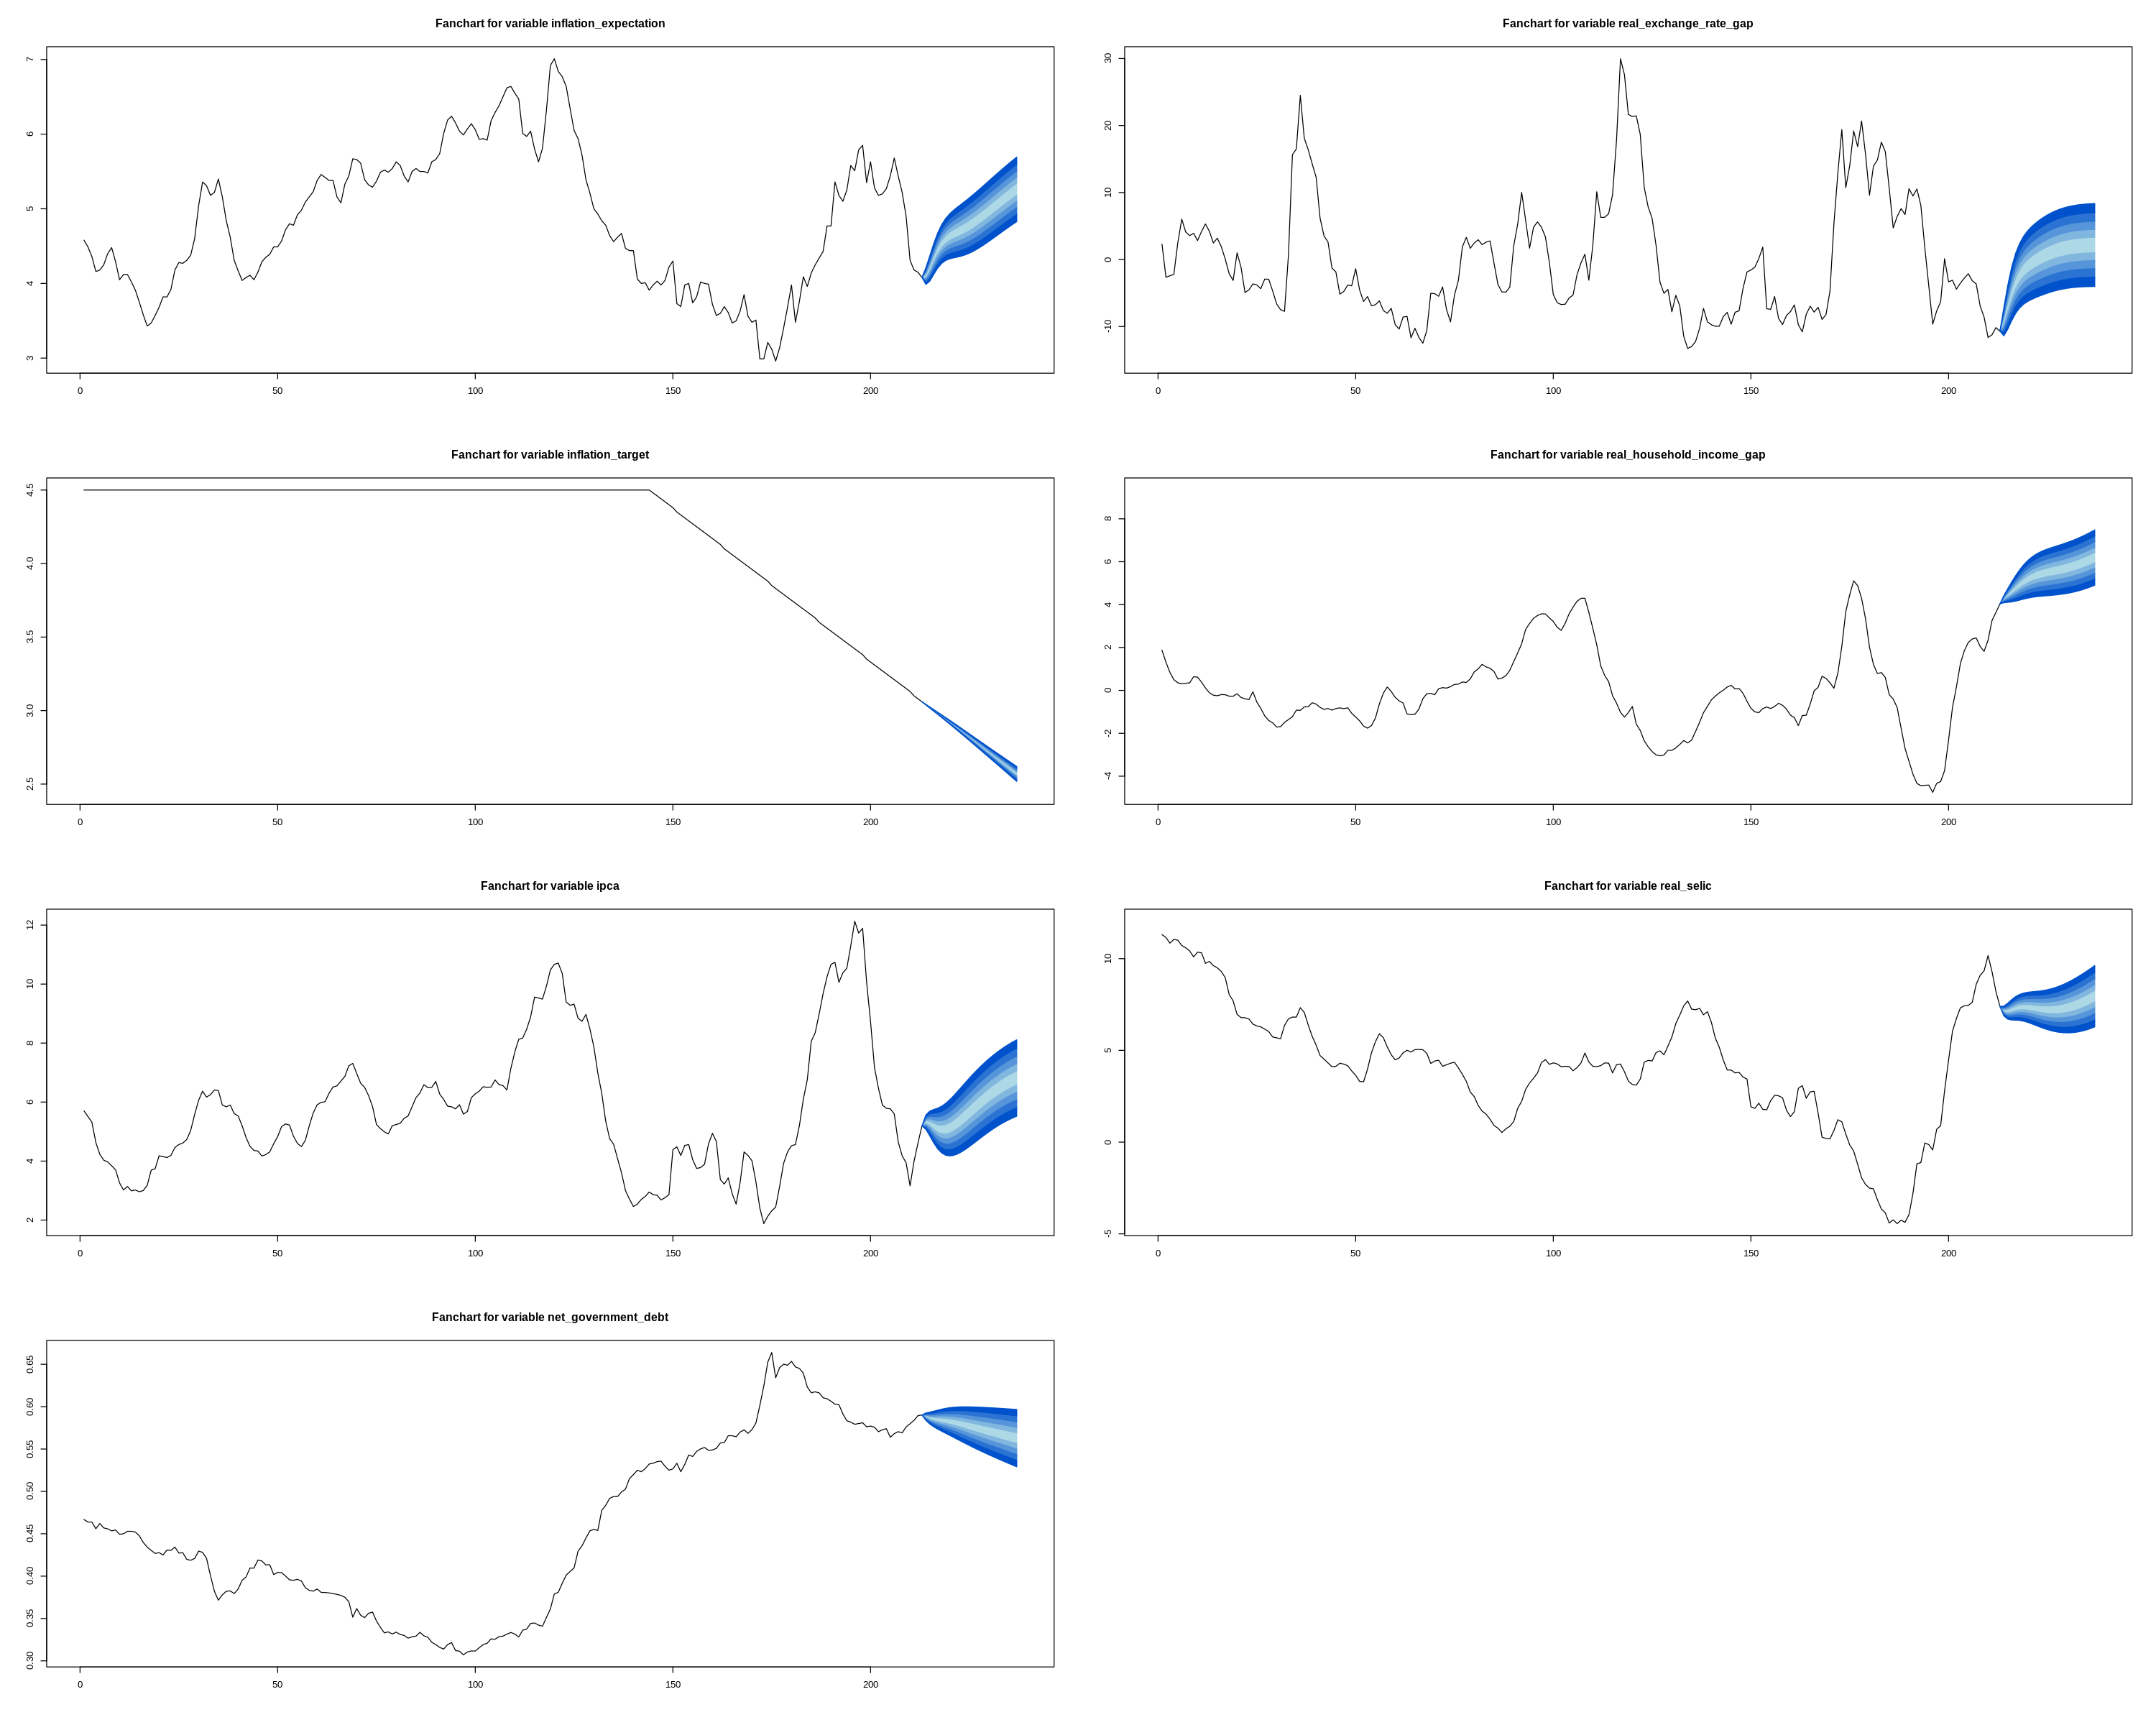

In [ ]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 25, repr.plot.height = 20)

# Forecast using VAR
forecast_var <- predict(var_model, n.ahead = 24, ci = 0.95)

# Definir um degradê de cores azul com 5 tons
blue_gradient <- colorRampPalette(c("#ADD8E6", "#0052CC"))(5)

# Criar um gráfico de intervalo de previsão usando o degradê azul personalizado com 5 tons
fanchart(forecast_var, colors=blue_gradient)

### **Modelo VECM**

In [ ]:
# Selecionar variáveis do modelo VECM
vecm_model_variables <- df_public_data[, c("market_inflation_expectation", "inflation_target_wtd_avg", "ipca", "primary_fiscal_result_to_gdp", "real_exchange_rate_gap", "real_household_income_gap", "selic_deflated")]

# Renomear variáveis
vecm_model_variables <- vecm_model_variables %>% rename(inflation_expectation = market_inflation_expectation)
vecm_model_variables <- vecm_model_variables %>% rename(inflation_target = inflation_target_wtd_avg)
vecm_model_variables <- vecm_model_variables %>% rename(net_government_debt = primary_fiscal_result_to_gdp)
vecm_model_variables <- vecm_model_variables %>% rename(real_selic = selic_deflated)

In [171]:
# Lag Selection (n-1)
vecm_lag <- VARselect(vecm_model_variables, lag.max = 12, type = "const")

print(vecm_lag$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    12      2      2      4 


In [172]:
# Johansen Test (Trace)
vecm_johansen_trace <- ca.jo(vecm_model_variables, type = "trace", ecdet = "const", K = 2)

summary(vecm_johansen_trace)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1] 2.014515e-01 1.738203e-01 1.448735e-01 1.251917e-01 8.533302e-02
[6] 5.458442e-02 2.282324e-03 6.288373e-18

Values of teststatistic and critical values of test:

           test  10pct   5pct   1pct
r <= 6 |   0.48   7.52   9.24  12.97
r <= 5 |  12.33  17.85  19.96  24.60
r <= 4 |  31.15  32.00  34.91  41.07
r <= 3 |  59.37  49.65  53.12  60.16
r <= 2 |  92.39  71.86  76.07  84.45
r <= 1 | 132.68  97.18 102.14 111.01
r = 0  | 180.15 126.58 131.70 143.09

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                             inflation_expectation.l2 inflation_target.l2
inflation_expectation.l2                  1.000000000          1.00000000
inflation_target.l2                      -1.882823947          0.98585239
ipca.l2                                  -0.586065731

**Resultado**

- r <= 3: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 3 relações de cointegração no sistema

- r <= 4: Como teststatistic é menor que critical value a um nível de significância de 5%, não se rejeita a hipótese nula, ou seja, existe no máximo 3 relações de cointegração no sistema

In [173]:
# Johansen Test (MaxEigen)
vecm_johansen_eigen <- ca.jo(vecm_model_variables, type = "eigen", ecdet = "const", K = 2)

summary(vecm_johansen_eigen)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1] 2.014515e-01 1.738203e-01 1.448735e-01 1.251917e-01 8.533302e-02
[6] 5.458442e-02 2.282324e-03 6.288373e-18

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 6 |  0.48  7.52  9.24 12.97
r <= 5 | 11.84 13.75 15.67 20.20
r <= 4 | 18.82 19.77 22.00 26.81
r <= 3 | 28.22 25.56 28.14 33.24
r <= 2 | 33.02 31.66 34.40 39.79
r <= 1 | 40.29 37.45 40.30 46.82
r = 0  | 47.47 43.25 46.45 51.91

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                             inflation_expectation.l2 inflation_target.l2
inflation_expectation.l2                  1.000000000          1.00000000
inflation_target.l2                      -1.882823947          0.98585239
ipca.l2                                  -0.586065731      

**Resultado**

- r <= 3: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 3 relações de cointegração no sistema

- r <= 4: Como teststatistic é menor que critical value a um nível de significância de 5%, não se rejeita a hipótese nula, ou seja, existe no máximo 3 relações de cointegração no sistema

In [174]:
# Criar modelo VECM
vecm_model <- VECM(vecm_model_variables, 2, r = 3, estim = "ML")

summary(vecm_model)

#############
###Model VECM 
#############
Full sample size: 213 	End sample size: 210
Number of variables: 7 	Number of estimated slope parameters 126
AIC -6560.064 	BIC -6098.163 	SSR 2134.64
Cointegrating vector (estimated by ML):
   inflation_expectation inflation_target          ipca net_government_debt
r1          1.000000e+00      6.14492e-16  0.000000e+00           -7.495693
r2          8.471862e-18      1.00000e+00 -1.387779e-17            6.865087
r3         -1.435036e-16      1.61734e-15  1.000000e+00          -21.386999
   real_exchange_rate_gap real_household_income_gap  real_selic
r1           0.0432110610                -0.4600719  0.21807831
r2           0.0006997977                 0.2480191 -0.03187462
r3          -0.0103211191                -0.6668134  0.41708762


                                   ECT1                ECT2               
Equation inflation_expectation     -0.1127(0.0295)***  -0.0203(0.0632)    
Equation inflation_target          0.0003(0.0004)     

In [175]:
# VECM specification to VAR specification
vecm_model_formatted <- vec2var(vecm_johansen_trace, r = 3)

In [176]:
# Serial Correlation
vecm_serial_test <- serial.test(vecm_model_formatted, lags.pt = 12, type = "PT.asymptotic")

print(vecm_serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 883, df = 497, p-value < 2.2e-16



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 883, df = 497, p-value < 2.2e-16



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [177]:
# Heteroscedasticity
vecm_arch_test <- arch.test(vecm_model_formatted, lags.multi = 12, multivariate.only = TRUE)

print(vecm_arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 5572, df = 9408, p-value = 1



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 5572, df = 9408, p-value = 1



**Resultado**

- Como o p-value é maior que um nível de significância de 5%, pode-se afirmar que o modelo não possui heteroscedasticidade

In [178]:
# Normal Distribution of Residuals
vecm_normal_test <- normality.test(vecm_model_formatted, multivariate.only = TRUE)

print(vecm_normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 3583.6, df = 14, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 180.51, df = 7, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 3403.1, df = 7, p-value < 2.2e-16




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 3583.6, df = 14, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 180.51, df = 7, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 3403.1, df = 7, p-value < 2.2e-16




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

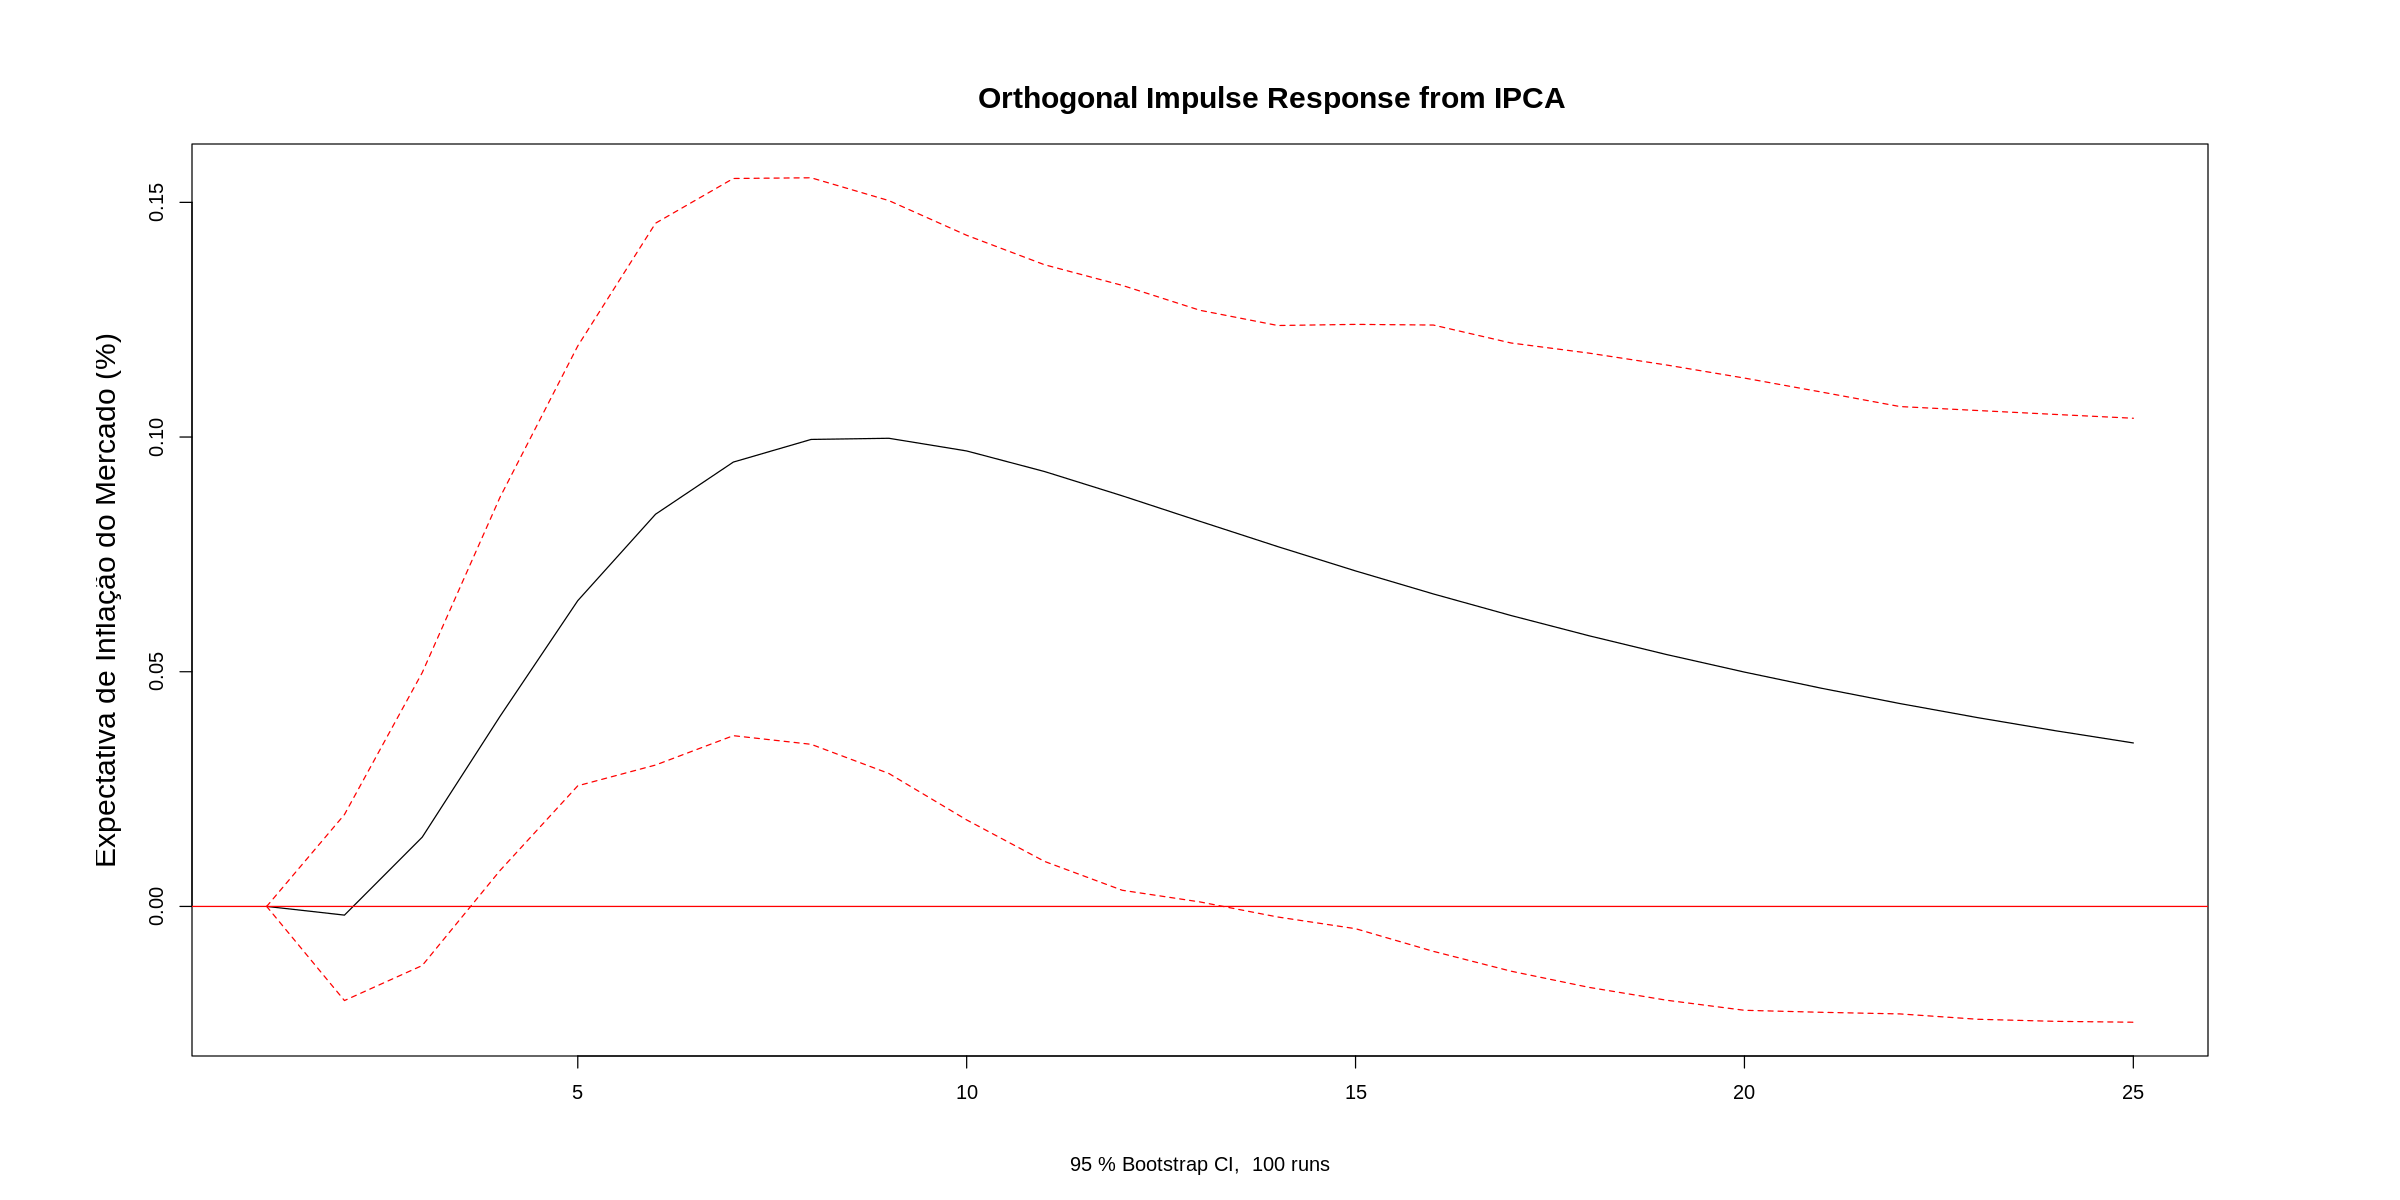

In [179]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 10)

# Impulse Response Function
vecm_ipca_market_expectation_impulse = irf(vecm_model_formatted, impulse = "ipca", response = "inflation_expectation", n.ahead = 24, boot = TRUE)

# Criar o gráfico com tamanho de rótulo do eixo y aumentado
plot(vecm_ipca_market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)", main = "", cex.lab = 1.5)
title("Orthogonal Impulse Response from IPCA", cex.main = 1.5)

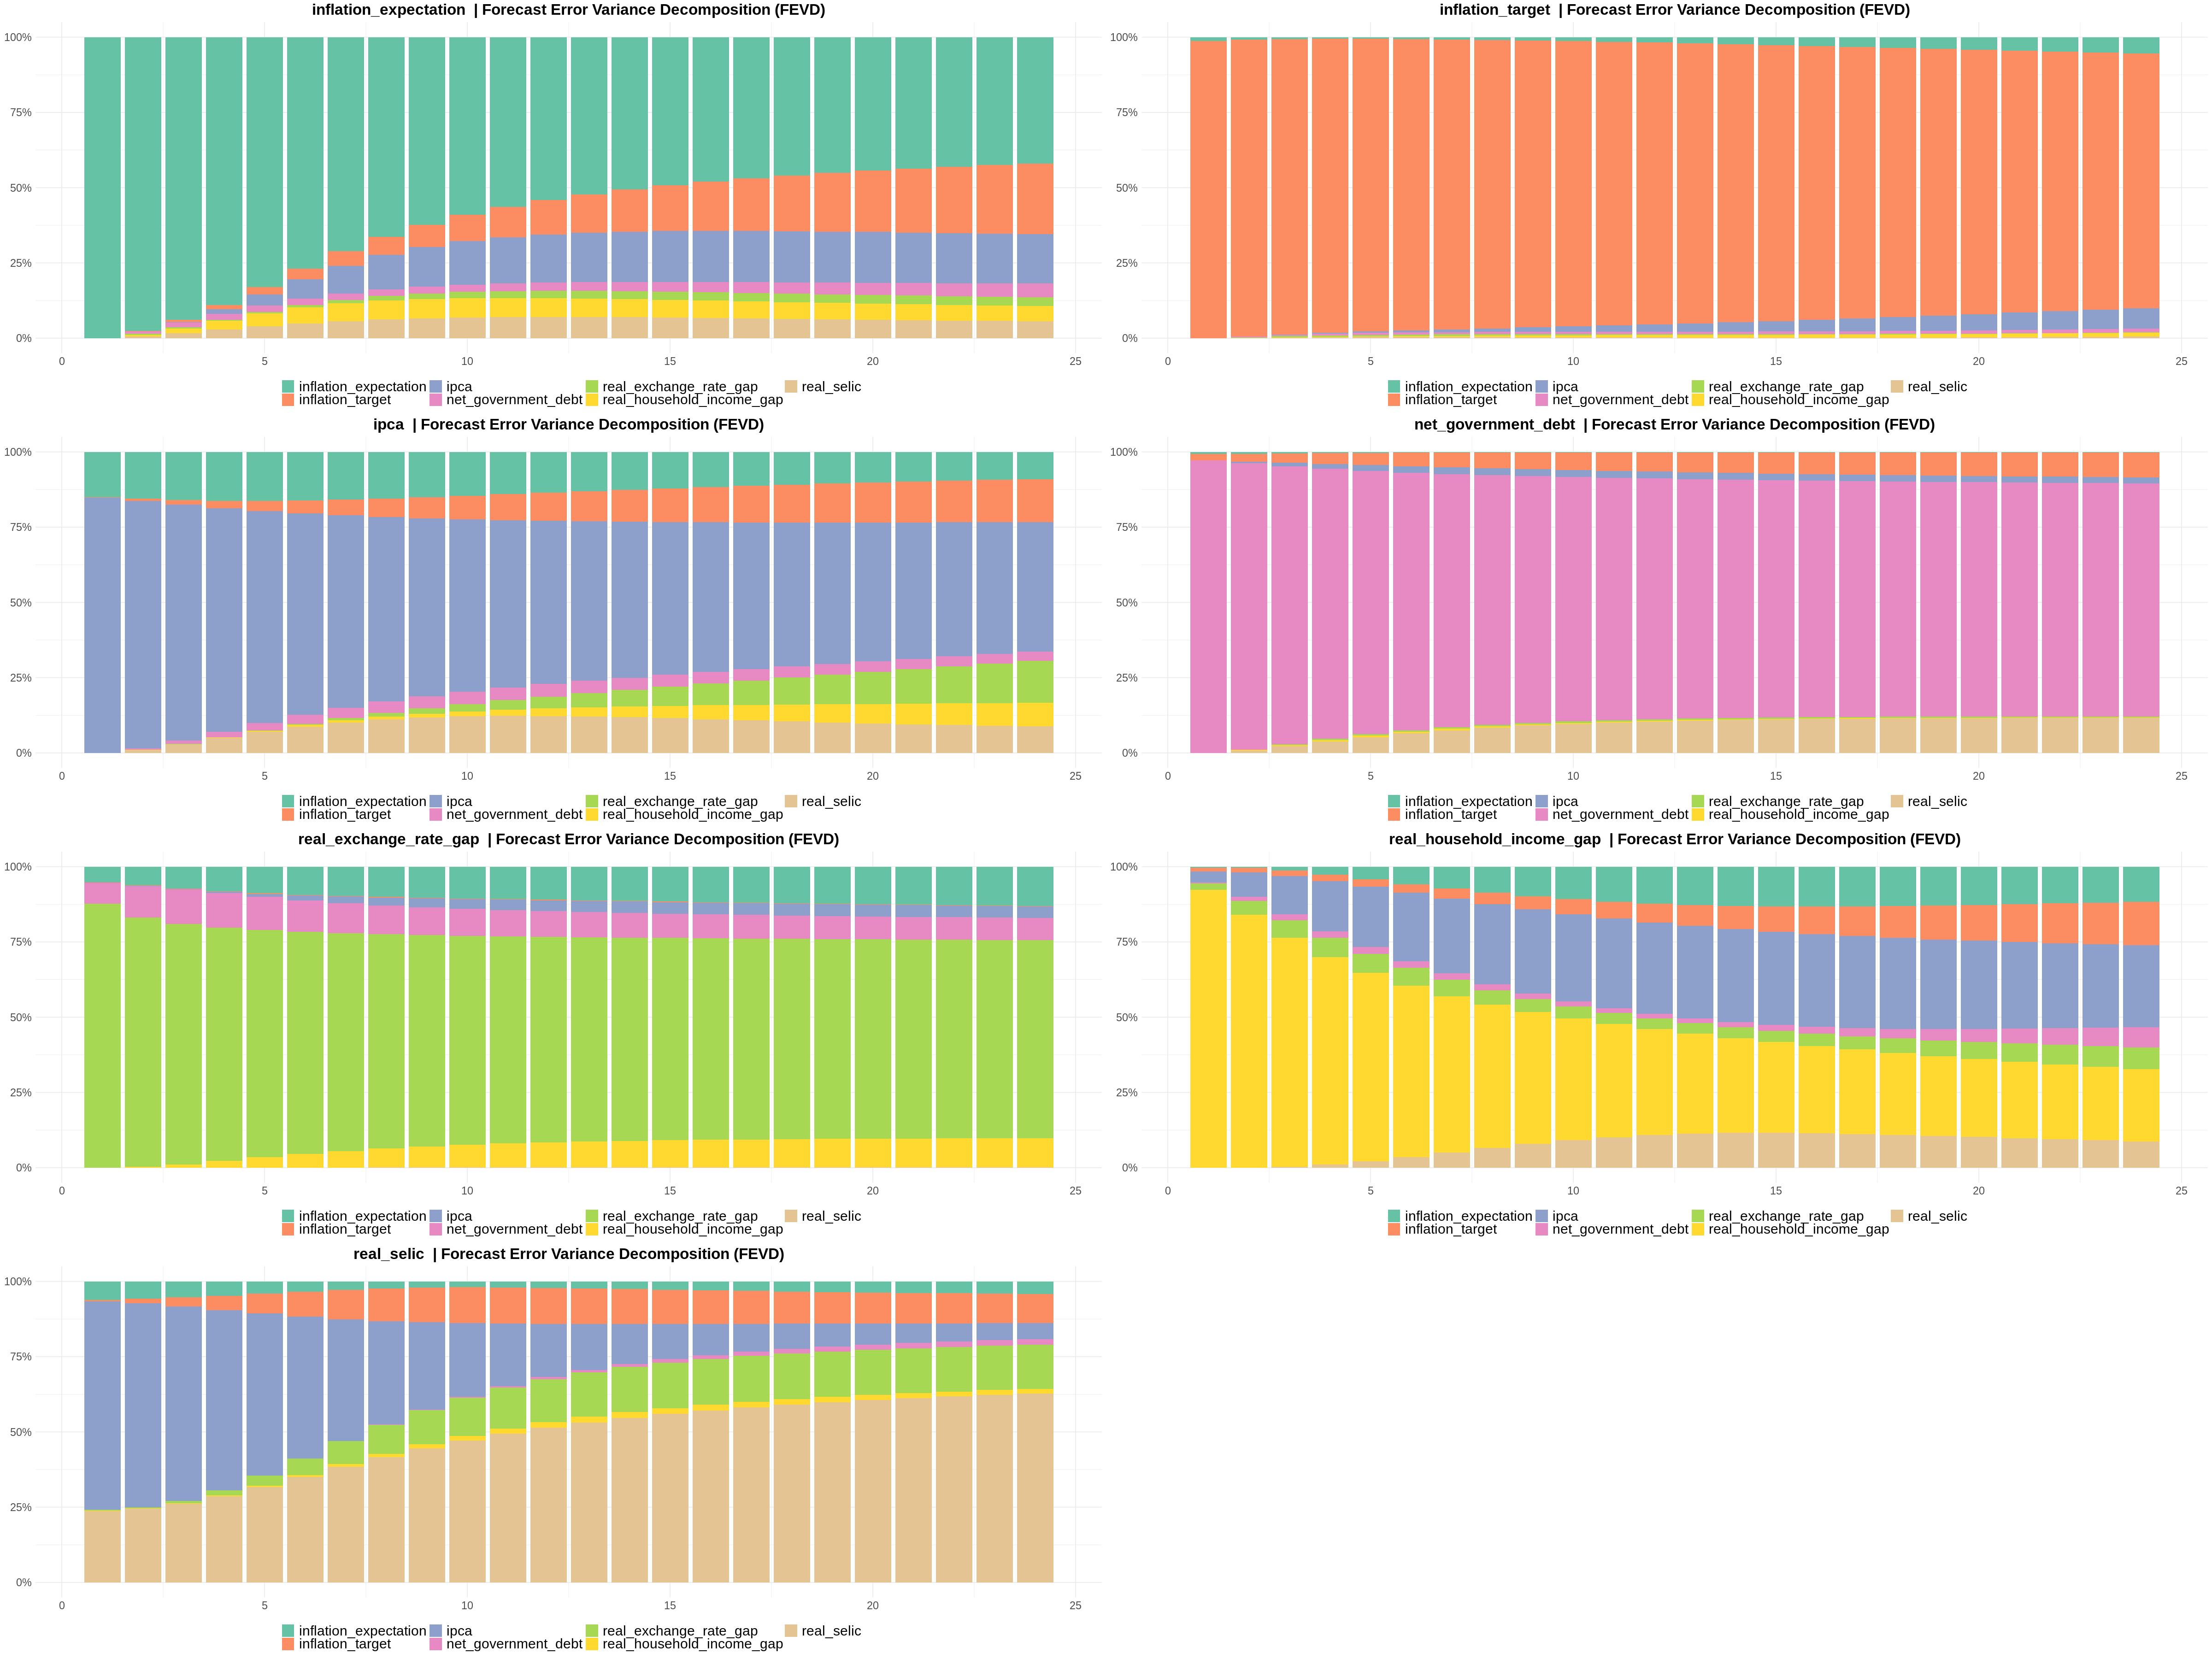

In [180]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 40, repr.plot.height = 30)

# Variance Decomposition
vecm_fevd <- fevd(vecm_model_formatted, n.ahead = 24)

# Criar uma lista com os data frames
data_list <- list(
  inflation_expectation = as.data.frame(vecm_fevd$inflation_expectation),
  inflation_target = as.data.frame(vecm_fevd$inflation_target),
  ipca = as.data.frame(vecm_fevd$ipca),
  net_government_debt = as.data.frame(vecm_fevd$net_government_debt),
  real_exchange_rate_gap = as.data.frame(vecm_fevd$real_exchange_rate_gap),
  real_household_income_gap = as.data.frame(vecm_fevd$real_household_income_gap),
  real_selic = as.data.frame(vecm_fevd$real_selic)
)

# Adicionar a coluna "Mes" de 1 a 24 a cada data frame
data_list <- lapply(data_list, function(df) {
  df$Mes <- 1:24
  return(df)
})

# Função para criar os gráficos
create_stacked_bar_plot <- function(data, title) {
  ggplot(data, aes(x = Mes, y = value, fill = Variavel)) +
    geom_bar(stat = "identity") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_brewer(palette = "Set2") +
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      legend.position = "bottom",
      axis.text = element_text(size = 14),
      legend.text = element_text(size = 18),
      plot.title = element_text(hjust = 0.5, size = 20, face = "bold")
    ) +
    labs(fill = NULL) +
    ggtitle(title)
}

# Criar os gráficos empilhados e armazená-los em uma lista
plot_list <- lapply(names(data_list), function(name) {
  data <- data_list[[name]]
  title <- paste(name, " | Forecast Error Variance Decomposition (FEVD)")
  data_long <- pivot_longer(data, cols = -Mes, names_to = "Variavel", values_to = "value")
  create_stacked_bar_plot(data_long, title)
})

# Plotar os gráficos em um painel
grid.arrange(grobs = plot_list, ncol = 2)  # Altere ncol conforme necessário

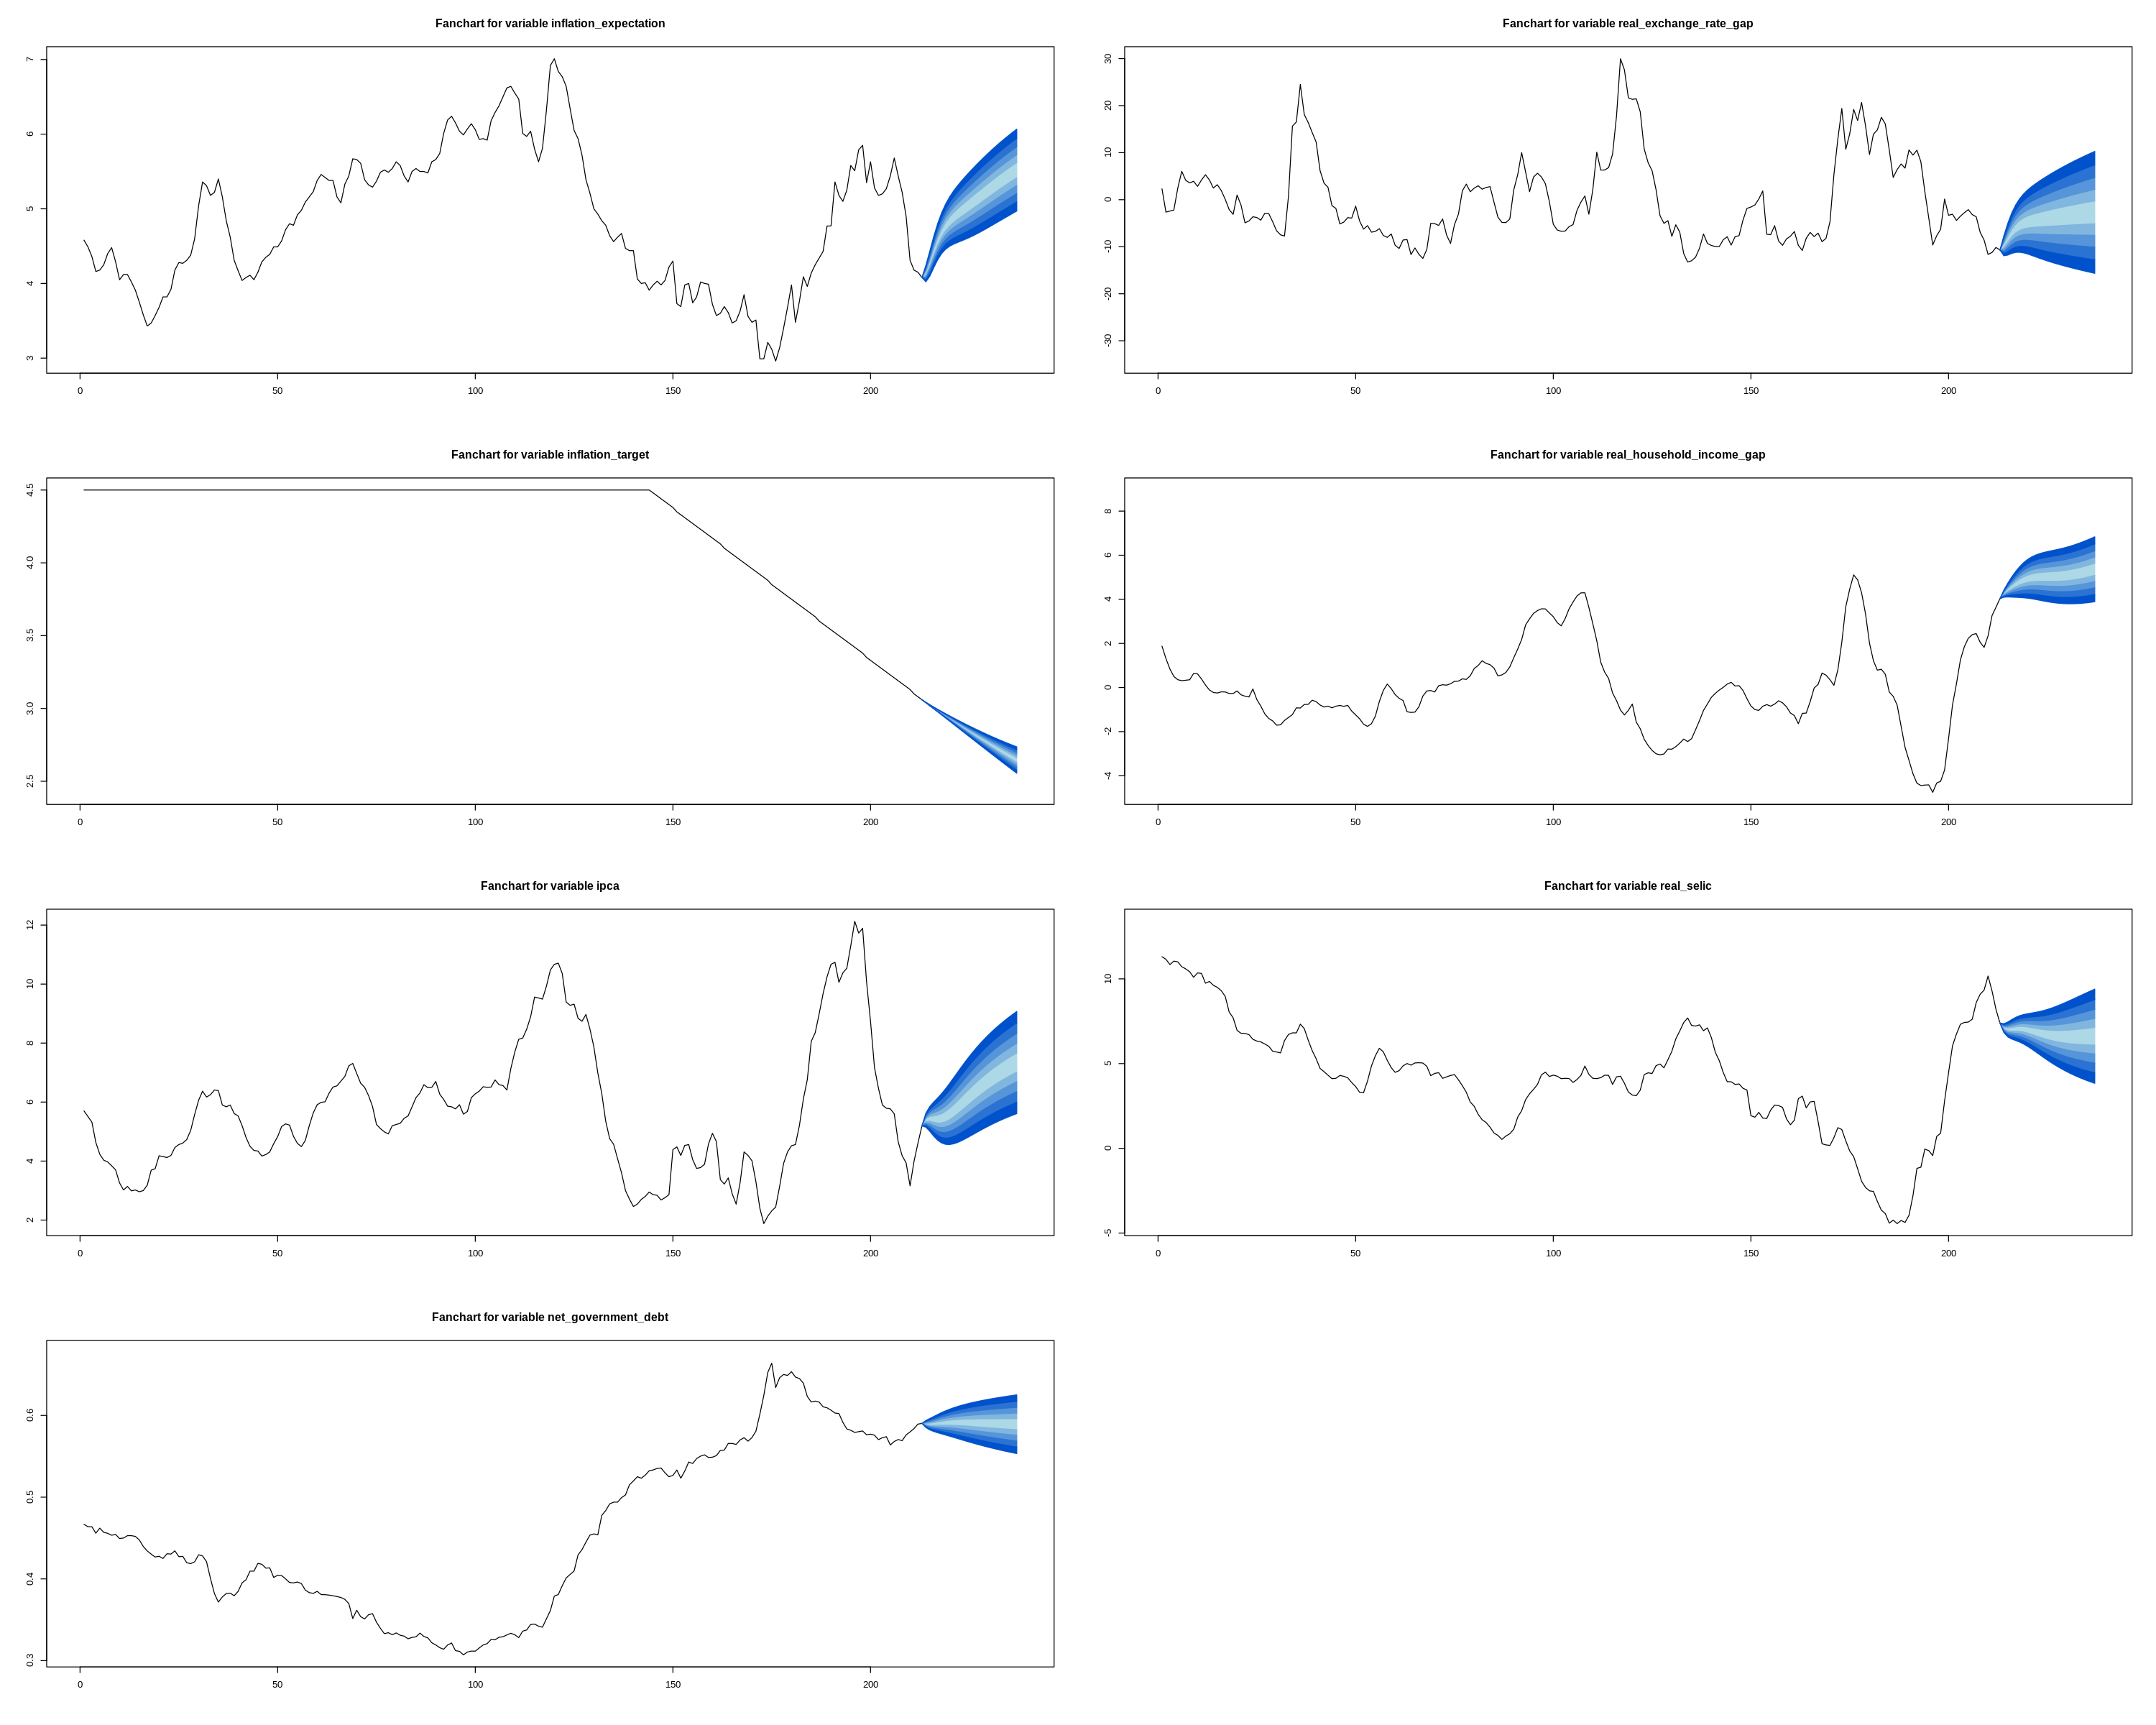

In [181]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 25, repr.plot.height = 20)

# Forecast using VAR
forecast_vecm <- predict(vecm_model_formatted, n.ahead = 24, ci = 0.95)

# Definir um degradê de cores azul com 5 tons
blue_gradient <- colorRampPalette(c("#ADD8E6", "#0052CC"))(5)

# Criar um gráfico de intervalo de previsão usando o degradê azul personalizado com 5 tons
fanchart(forecast_vecm, colors=blue_gradient)